# Xenium image display and processing

In [1]:

input_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/Xenium_output/output-XETG00171__0018212__Region_1__20240207__003742/'
#input_path ='/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/Xenium_output/output-XETG00171__0018212__Region_1__20240207__003742/'
#'/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/Xenium_output/output-XETG00171__0018220__Region_1__20240207__003742/'

outhput_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_TG-Region_1_UCHL1.tif'
#outhput_path ='/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018212_TG-Region_1.tif'
#'/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_1.tif'


In [10]:
import tifffile

#mipurl = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/output-XETG00171__0018220__Region_1__20240207__003742/morphology_mip.ome.tif'

mipurl = input_path + '/morphology_mip.ome.tif'


with tifffile.TiffFile(mipurl) as tif:
    for tag in tif.pages[0].tags.values():
        if tag.name == 'ImageDescription':
            print(tag.name+":", tag.value)

ImageDescription: <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" Creator="tifffile.py 2022.10.10" UUID="urn:uuid:2c3e730c-c56a-11ee-b31f-3cecefe152c4" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
    <Plate ID="Plate:1" WellOriginX="-0.0" WellOriginXUnit="µm" WellOriginY="-0.0" WellOriginYUnit="µm" />
    <Instrument ID="Instrument:1">
        <Microscope Manufacturer="10x Genomics" Model="Xenium" />
    </Instrument>
    <Image ID="Image:0" Name="Image0">
        <InstrumentRef ID="Instrument:1" />
        <Pixels DimensionOrder="XYZCT" ID="Pixels:0" SizeC="1" SizeT="1" SizeX="42698" SizeY="64642" SizeZ="1" Type="uint16" PhysicalSizeX="0.2125" PhysicalSizeY="0.2125">
            <Channel ID="Channel:0:0" Name="DAPI" SamplesPerPixel="1" />
            <TiffData PlaneCount="1" />
        </Pixels>
    </Image>
</OME>


In [3]:
with tifffile.TiffFile(mipurl) as tif:
    for i in range(len(tif.series[0].levels)):
        print(i, tif.series[0].levels[i].shape)

0 (64642, 42698)
1 (32321, 21349)
2 (16160, 10674)
3 (8080, 5337)
4 (4040, 2668)
5 (2020, 1334)
6 (1010, 667)
7 (505, 333)


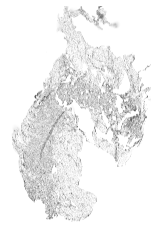

In [5]:
#[3] Plot Level 2 DAPI image with inverted color scale 
import tifffile
from matplotlib import pyplot as plt

with tifffile.TiffFile(mipurl) as tif:
    image = tif.series[0].levels[2].asarray()

plt.imshow(image, cmap='binary')
#plt.title('Level 4 DAPI', size=16)
#plt.axis('scaled')
plt.axis('off')
plt.savefig('foo.tif')
plt.show()

In [11]:
#[4] Resample Level 0 image dimensions
import scipy
import tifffile
from matplotlib import pyplot as plt
import scipy.ndimage

with tifffile.TiffFile(mipurl) as tif:
    image = tif.series[0].levels[4].asarray()

print(image.shape)
resample = scipy.ndimage.zoom(image, 1)
print(resample.shape)

(4040, 2668)
(4040, 2668)


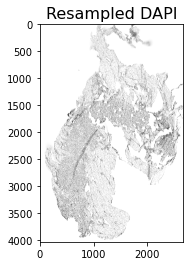

(4040, 2668)

In [28]:
#plt.imshow(resample, cmap='binary')
#plt.title('Resampled DAPI', size=16)
#plt.axis('scaled')
#plt.show()

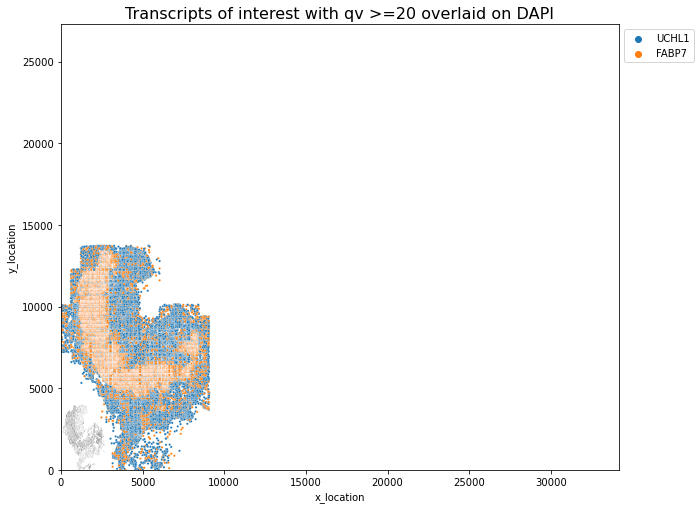

In [12]:
#[5] Overlay select (qv >= 20) transcripts on resampled image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read transcripts table
#wdir = r'/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/output-XETG00171__0018220__Region_2__20240207__003742/'
wdir = input_path


transcriptsurl = f'{wdir}transcripts.parquet'
transcripts = pd.read_parquet(transcriptsurl)
#transcripts['feature_name'] = transcripts['feature_name'].apply(lambda x: x.decode('utf-8'))
transcripts['feature_name'] = transcripts['feature_name'].astype(str)

# Subset transcripts to region of interest and quality value >= 20
subset = transcripts[
    (transcripts['x_location'] > 0) & (transcripts['x_location'] < 34174) &
    (transcripts['y_location'] > 0) & (transcripts['y_location'] < 27280) &
    (transcripts['qv'] >= 20)]

# Define transcript features of interest
genes = ['UCHL1', 'FABP7']

# Plot resampled image from [4]
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(resample, cmap='binary')

# Plot features of interest
sns.scatterplot(
    x = 'x_location', y = 'y_location',
    data = subset[subset['feature_name'].isin(genes)],
    hue = 'feature_name', s = 5, alpha = 1,
)
plt.title('Transcripts of interest with qv >=20 overlaid on DAPI', size=16)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.axis('scaled')
plt.xlim(0,34174)
plt.ylim(0,27280)
plt.show()

<ipython-input-7-303955baa659>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['x_location_scaled'] = subset['x_location'] / rescale_factor
<ipython-input-7-303955baa659>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['y_location_scaled'] = subset['y_location'] / rescale_factor


<AxesSubplot:xlabel='x_location_scaled', ylabel='y_location_scaled'>

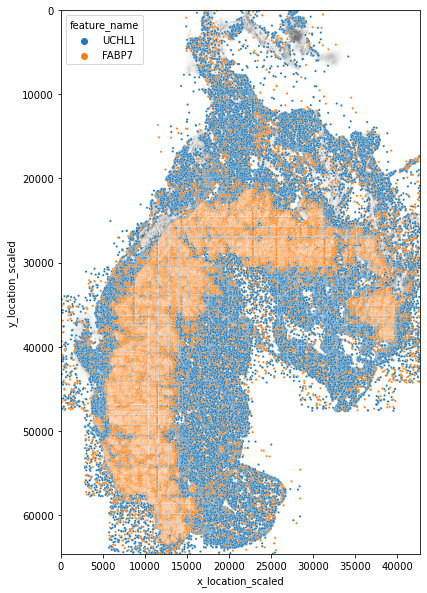

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming previous steps for loading `transcripts` and `resample` have been done

# Rescale factor from original to resampled image
rescale_factor = 0.2125

# Adjust the transcripts' coordinates to match the resampled image scale
subset['x_location_scaled'] = subset['x_location'] / rescale_factor
subset['y_location_scaled'] = subset['y_location'] / rescale_factor

# Plot resampled image
plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(resample, cmap='binary')

# Plot features of interest with scaled coordinates
sns.scatterplot(
    x='x_location_scaled', y='y_location_scaled',
    data=subset[subset['feature_name'].isin(genes)],
    hue='feature_name', s=5, alpha=1,
)

# Adjusting the plot
#plt.title('Transcripts of interest with qv >=20 overlaid on DAPI', size=16)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
#plt.axis('scaled')
# Adjust limits based on the resampled image dimensions
#plt.xlim(0, resample.shape[1])  # Width of resampled image
#plt.ylim(resample.shape[0], 0)  # Height of resampled image, inverted y-axis for correct orientation
#plt.show()

# Save the figure
#plt.savefig('/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/your_image.tiff', format='tiff')


In [8]:
#from PIL import Image, ImageDraw

# ... previous code ...

# Convert your resampled array to a PIL image
# Ensure the image is in RGB mode
#if resample.ndim == 2:  # Grayscale
#    pil_img = Image.fromarray(np.uint8(resample)).convert('RGB')
#elif resample.ndim == 3 and resample.shape[2] == 3:  # RGB
    #pil_img = Image.fromarray(np.uint8(resample))
#else:
    #raise ValueError('Unsupported image shape')

# Define a dictionary mapping specific feature names to colors
#feature_colors = {
    #'UCHL1': (128, 0, 128),  # Purple, in RGB tuple format
    #'FABP7': (255, 0, 0),    # Red, in RGB tuple format
    # Add more mappings as needed
#}

# Create a draw object to annotate the image
#draw = ImageDraw.Draw(pil_img)

# Loop through your subset DataFrame and draw points with colors based on feature_name
#for index, row in subset.iterrows():
    # Get the color for the current row's feature_name
    #color = feature_colors.get(row['feature_name'], (255, 255, 255))  # Default to white if feature_name not in dictionary
    
    # Coordinates for the transcript
    #x = row['x_location_scaled']
    #y = row['y_location_scaled']
    
    # Draw a small circle or point for each transcript with the specified color
    #draw.ellipse((x-2, y-2, x+2, y+2), fill=color)

# Save the annotated image directly, adjusting the path as necessary, in TIFF format
#pil_img.save(r'/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/annotated_image_color-1.tif', format='TIFF')


In [13]:
from PIL import Image, ImageDraw
import numpy as np

# Assuming resample is your image data and subset is your DataFrame

# Convert your resampled array to a PIL image
# Ensure the image is in RGB mode
if resample.ndim == 2:  # Grayscale
    pil_img = Image.fromarray(np.uint8(resample)).convert('RGB')
elif resample.ndim == 3 and resample.shape[2] == 3:  # RGB
    pil_img = Image.fromarray(np.uint8(resample))
else:
    raise ValueError('Unsupported image shape')

# Define a dictionary mapping specific feature names to colors
feature_colors = {
    'UCHL1': (0, 255, 0),  # Purple, in RGB tuple format
    #'FABP7': (255, 0, 0),    # Red, in RGB tuple format
    # Add more mappings as needed
}

# Create a draw object to annotate the image
draw = ImageDraw.Draw(pil_img)

# Loop through your subset DataFrame and draw points with colors based on feature_name
for index, row in subset.iterrows():
    # Check if the feature_name is in the dictionary
    if row['feature_name'] in feature_colors:
        # Get the color for the current row's feature_name
        color = feature_colors[row['feature_name']]
        
        # Coordinates for the transcript
        x = row['x_location_scaled']
        y = row['y_location_scaled']
        
        # Draw a small circle or point for each transcript with the specified color
        draw.ellipse((x-2, y-2, x+2, y+2), fill=color)
    # If feature_name is not in the dictionary, do not draw anything (skip)

# Save the annotated image directly, adjusting the path as necessary, in TIFF format
pil_img.save(outhput_path, format='TIFF')



KeyError: 'x_location_scaled'

### Black background images

In [71]:

#input_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/Xenium_output/output-XETG00171__0018220__Region_4__20240207__003742/'
input_path ='/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/Xenium_output/output-XETG00171__0018220__Region_4__20240207__003742/'
#'/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/Xenium_output/output-XETG00171__0018220__Region_1__20240207__003742/'

#output_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_4_black_background-2.tif'
output_path ='/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_4_FABP7_G.tif'
#'/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_1.tif'

In [72]:
import tifffile

#mipurl = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/output-XETG00171__0018220__Region_1__20240207__003742/morphology_mip.ome.tif'

mipurl = input_path + '/morphology_mip.ome.tif'


with tifffile.TiffFile(mipurl) as tif:
    for tag in tif.pages[0].tags.values():
        if tag.name == 'ImageDescription':
            print(tag.name+":", tag.value)

ImageDescription: <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" Creator="tifffile.py 2022.10.10" UUID="urn:uuid:f8a60030-c570-11ee-a73b-3cecefe152c4" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
    <Plate ID="Plate:1" WellOriginX="-0.0" WellOriginXUnit="µm" WellOriginY="-0.0" WellOriginYUnit="µm" />
    <Instrument ID="Instrument:1">
        <Microscope Manufacturer="10x Genomics" Model="Xenium" />
    </Instrument>
    <Image ID="Image:0" Name="Image0">
        <InstrumentRef ID="Instrument:1" />
        <Pixels DimensionOrder="XYZCT" ID="Pixels:0" SizeC="1" SizeT="1" SizeX="17170" SizeY="27295" SizeZ="1" Type="uint16" PhysicalSizeX="0.2125" PhysicalSizeY="0.2125">
            <Channel ID="Channel:0:0" Name="DAPI" SamplesPerPixel="1" />
            <TiffData PlaneCount="1" />
        </Pixels>
    </Image>
</OME>


In [73]:
with tifffile.TiffFile(mipurl) as tif:
    image_size_original=tif.series[0].levels[0].shape
    for i in range(len(tif.series[0].levels)):
        print(i, tif.series[0].levels[i].shape)

0 (27295, 17170)
1 (13647, 8585)
2 (6823, 4292)
3 (3411, 2146)
4 (1705, 1073)
5 (852, 536)
6 (426, 268)


In [74]:
import pandas as pd
from PIL import Image, ImageDraw

# Assuming `input_path`, `output_path`, `factor`, and `image_size_original` are defined earlier in your script
data_file_path = input_path + 'transcripts.csv'  # Ensure `input_path` ends with a slash (/)
output_image_path = output_path  # Ensure this variable is correctly defined
factor = 0.2125  # Scaling factor to convert pixel into micrometer

# Adjust `image_size_original` function or variable appropriately to get original image size
image_size = (int(image_size_original[1]*factor), int(image_size_original[0]*factor))

# Gene names and colors to plot: Add or modify entries here as needed
genes_to_plot = {
    #'UCHL1': (255, 0, 0),  # Red
    'FABP7': (0, 255, 0),  # Green
    # Add more genes and their colors here as needed
}

# Read the spatial sequencing data
data = pd.read_csv(data_file_path)

# Create a black image
image = Image.new('RGB', image_size, 'black')
draw = ImageDraw.Draw(image)

# Scale the x_location and y_location by 'factor'
data['x_location_scaled'] = data['x_location'] 
data['y_location_scaled'] = data['y_location'] 

# Plot the points for the specified genes with qv > 20
for index, row in data.iterrows():
    if row['qv'] > 20 and row['feature_name'] in genes_to_plot:
        color = genes_to_plot[row['feature_name']]
        # Plot the gene
        draw.point((row['x_location_scaled'], row['y_location_scaled']), fill=color)

# Save the image
image.save(output_image_path, format='TIFF')

print(f"Image saved to {output_image_path}")

Image saved to /media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_4_FABP7_G.tif


# Generate the Xenium gene expression matrix based on the FIJI manually annotated cell segementaions

### Check the format of FIJI ROI file

In [24]:


import read_roi

# Path to your .roi file
roi_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/RoiSet/13303-11954.roi'

# Reading the .roi file
roi = read_roi.read_roi_file(roi_file_path)

# Printing the contents of the .roi file
print(roi)

{'13303-11954': {'type': 'freehand', 'x': [11930, 11927, 11913, 11908, 11902, 11900, 11896, 11894, 11882, 11879, 11868, 11862, 11859, 11858, 11842, 11840, 11838, 11833, 11832, 11832, 11827, 11826, 11824, 11823, 11822, 11822, 11819, 11818, 11818, 11818, 11818, 11819, 11820, 11823, 11825, 11829, 11830, 11831, 11834, 11835, 11836, 11846, 11846, 11847, 11853, 11854, 11854, 11859, 11861, 11862, 11867, 11867, 11868, 11874, 11876, 11888, 11889, 11898, 11900, 11908, 11910, 11919, 11920, 11921, 11922, 11923, 11925, 11926, 11930, 11932, 11933, 11941, 11942, 11959, 11960, 11965, 11966, 11967, 11971, 11972, 11973, 11981, 11982, 11985, 11992, 11993, 12012, 12013, 12025, 12028, 12039, 12040, 12042, 12048, 12049, 12051, 12052, 12052, 12054, 12058, 12058, 12059, 12063, 12064, 12064, 12064, 12064, 12065, 12065, 12065, 12065, 12065, 12064, 12059, 12058, 12058, 12057, 12054, 12054, 12054, 12052, 12052, 12052, 12082, 12083, 12084, 12084, 12086, 12088, 12088, 12090, 12089, 12085, 12069, 12061, 12058, 12056

### Combine all FIJI ROIs into one JSON file

In [42]:
# To combine the contents of multiple .roi files into a single .json file, first, we need to extract the .roi files from the zip,
# then read each .roi file, and finally, combine their contents into a single dictionary and save it as a .json file.

import zipfile
import json
import read_roi

# Path to the zip file containing .roi files
zip_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC.zip'

# The dictionary to hold all the ROI data
combined_roi_data = {}

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract .roi files names
    roi_files = [f for f in zip_ref.namelist() if f.endswith('.roi')]
    
    # Temporary directory to extract files
    temp_dir = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/tem'
    
    # Extract .roi files
    zip_ref.extractall(temp_dir)
    
    # Read each .roi file and add its content to the combined dictionary
    for roi_file in roi_files:
        # Path to the extracted .roi file
        file_path = f"{temp_dir}/{roi_file}"
        
        # Read the .roi file
        roi_data = read_roi.read_roi_file(file_path)
        
        # Combine data
        combined_roi_data.update(roi_data)

# Define the path for the combined .json file
json_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC.json'

# Save the combined ROI data to a .json file
with open(json_file_path, 'w') as json_file:
    json.dump(combined_roi_data, json_file)

# Note: Update '/path/to/your/rois.zip' and '/path/to/combined_rois.json' with the actual paths
# Also, ensure that the 'read_roi' library is installed and available in your environment


### Scale JSON file coordinates to real size (1 pixel equal to 1 micrometer)

In [43]:
# To modify a .json file by multiplying all "x" and "y" values by a factor "a" and save the result to another file,
# follow these steps:

import json

def modify_json_values(input_file_path, output_file_path, factor):
    # Load the JSON data
    with open(input_file_path, 'r') as file:
        data = json.load(file)
    
    # Modify "x" and "y" values by multiplying by the factor
    for key in data.keys():
        if 'x' in data[key] and 'y' in data[key]:
            data[key]['x'] = [x * factor for x in data[key]['x']]
            data[key]['y'] = [y * factor for y in data[key]['y']]
    
    # Save the modified data to another JSON file
    with open(output_file_path, 'w') as file:
        json.dump(data, file, indent=4)

# Example usage
input_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC.json'  # Update this path
output_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC_real_size.json'  # Update this path
factor = 0.2125  # Example factor, update as needed

# Call the function to modify the JSON file
modify_json_values(input_file_path, output_file_path, factor)

# Note: Ensure you replace 'path/to/original.json' and 'path/to/modified.json' with the actual paths to your JSON files.
# Also, adjust the 'factor' variable as needed for your specific use case.


### Check whether Json file contains bad ROI

In [44]:
import json

# Path to the JSON file
json_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC_real_size.json'  # Update this path

# Load the JSON file
with open(json_file_path, 'r') as file:
    cell_segmentations = json.load(file)

# List to keep track of cell segmentations that do not meet the criteria
invalid_segmentations = []

# Iterate through each cell segmentation
for cell_id, seg_info in cell_segmentations.items():
    # Initialize a flag to track if the current segmentation is valid
    is_valid = True
    
    # Check if the type is 'freehand'
    if seg_info.get('type') != 'freehand':
        print(f"Segmentation {cell_id} does not have type 'freehand'.")
        is_valid = False
    
    # Check if there are at least 3 'x' and 3 'y' values
    if len(seg_info.get('x', [])) < 3 or len(seg_info.get('y', [])) < 3:
        print(f"Segmentation {cell_id} does not contain at least 3 'x' and 3 'y' values.")
        is_valid = False
    
    # If the segmentation does not meet the criteria, add its ID to the list
    if not is_valid:
        invalid_segmentations.append(cell_id)

# Check if there are any invalid segmentations
if invalid_segmentations:
    print("The following cell segmentations do not meet the criteria:")
    for cell_id in invalid_segmentations:
        print(cell_id)
else:
    print("All cell segmentations meet the criteria.")


All cell segmentations meet the criteria.


### If Json file contains bad ROI, remove these ROI and save a filtered JSON file

In [45]:
import json

# Path to the original JSON file
json_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC_real_size.json'

# Path to the new JSON file for saving the filtered segmentations
new_json_file_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC_real_size_filtered.json

# Load the JSON file
with open(json_file_path, 'r') as file:
    cell_segmentations = json.load(file)

# Dictionary to keep the valid cell segmentations
valid_segmentations = {}

# Iterate through each cell segmentation
for cell_id, seg_info in cell_segmentations.items():
    # Check if the segmentation meets the criteria:
    # 1. Type is 'freehand'
    # 2. Contains at least 3 'x' and 3 'y' values
    if seg_info.get('type') == 'freehand':
        if len(seg_info.get('x', [])) >= 3 and len(seg_info.get('y', [])) >= 3:
            valid_segmentations[cell_id] = seg_info
        else:
            print(f"Segmentation {cell_id} does not contain at least 3 'x' and 3 'y' values.")
    else:
        print(f"Segmentation {cell_id} does not have type 'freehand'.")

# Save the valid segmentations to a new JSON file
with open(new_json_file_path, 'w') as new_file:
    json.dump(valid_segmentations, new_file, indent=4)

print(f"Filtered cell segmentations saved to {new_json_file_path}.")


SyntaxError: EOL while scanning string literal (<ipython-input-45-4a93b7d0055d>, line 7)

### Read the Xenium transcript.csv data and map each gene expression in the new cell segemenation and save a gene expression matrix. csv file 

In [46]:
## Remap the transcript to the new segementation

import json
import pandas as pd
from matplotlib.path import Path

# Load the JSON file with cell segmentation information
with open('/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_RoiSet_10NC_real_size.json', 'r') as f:
    cell_segmentations = json.load(f)

# Load the CSV file with spatial sequencing data
spatial_data = pd.read_csv('/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/Xenium_output/output-XETG00171__0018220__Region_2__20240207__003742/transcripts.csv')

# Prepare a dictionary to hold the count of dots for each gene in each cell segmentation, excluding certain genes
counts = {}

# Iterate through each cell segmentation        
for cell_id, seg_info in cell_segmentations.items():
    # Convert segmentation points to a path for point-in-polygon test
    polygon = list(zip(seg_info['x'], seg_info['y']))
    path = Path(polygon)
    
    # Filter spatial data points that fall within the current cell segmentation
    points = spatial_data[['x_location', 'y_location']].values
    mask = path.contains_points(points)
    filtered_data = spatial_data[mask]
    
    # Exclude genes with names starting with "UnassignedCodeword"
    filtered_data = filtered_data[~filtered_data['feature_name'].str.startswith('UnassignedCodeword')]
    
    # Count the occurrences of each gene within this cell segmentation
    gene_counts = filtered_data['feature_name'].value_counts().to_dict()
    
    # Store the counts for the current cell segmentation
    counts[cell_id] = gene_counts

# Convert the counts dictionary to a DataFrame for easy manipulation and saving
output_df = pd.DataFrame.from_dict(counts, orient='index').fillna(0).astype(int)

# Transpose the DataFrame so that genes are rows and cell IDs are columns
output_df = output_df.transpose()

# Save the output DataFrame to a new CSV file
output_df.to_csv('/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/XETG00171__0018220_DRG-Region_2_gene_expression_matrix.csv')


# Generate spatial distribution of human DRG neurons 

## Figure 5A

In [6]:
import json
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Load your TIFF image
image_path = r'C:\Users\huash\Downloads\Xenium data processing\Xenium data processing\XETG00171__0018220_DRG-Region_1_gray.tif'
image = Image.open(image_path)
if image.mode != 'RGB':
    image = image.convert('RGB')

# Load and parse the JSON file
json_path = r'C:\Users\huash\Downloads\Xenium data processing\Xenium data processing\XETG00171__0018220_DRG-Region_1_RoiSet_real_size.json'
with open(json_path, 'r') as f:
    segmentations = json.load(f)

# Load the CSV file
csv_path = r'C:\Users\huash\Downloads\Xenium data processing\Xenium data processing\hDRG_gene_expression_matrix_metadata_seurat.csv'
df = pd.read_csv(csv_path)

# Define colors for each cell type in 'cell_type_manual'
colors = {'hTRPM8': '#00b8e7',
 'hC.LTMR': '#FF99FF',
 'hNP1': '#6666FF',
 'hNP2': '#00a9ff', 
 'hSST': '#8494ff',  
 'hPEP.TRPV1/A1': '#c77cff',
 'hPEP.PIEZOh': '#ff9933',
 'hPEP.KIT': '#ff68a1',
 'hPEP.CHRNA7': '#ff3333',
 'hPEP.NTRK3': '#ed68ed',
 'hPEP.0': '#dcc66e', 
 'hAd.LTMR': '#0cb702',
 'hAb.LTMR': '#aba300',          
 'hPropr': '#7cae00'
         }

# Create a drawing context
draw = ImageDraw.Draw(image)

# Iterate through each segmentation
for seg_id, seg_info in segmentations.items():
    if 'x' not in seg_info:
        continue  # Ignore segmentation if 'x' coordinate information is missing
    x_coords = seg_info['x']
    y_coords = seg_info['y']
    points = list(zip(x_coords, y_coords))

    # Assume the 'name' field maps to 'cell_id' in the CSV and find the cell type
    name = seg_info['name']
    cell_type = df[df['cell_id'] == name]['cell_type_manual'].values[0] if not df[df['cell_id'] == name].empty else None

    # Get color based on cell type, default to white if not found or no cell type
    color = colors.get(cell_type, (255, 255, 255))

    # Draw the segmentation
    draw.polygon(points, outline=color, fill=color)

# Optionally create a legend for the color mappings
# Adjust positioning and font size based on your image size
try:
    font = ImageFont.truetype("arial.ttf", size=150)  # Ensure you have this font or specify another
except IOError:
    font = ImageFont.load_default()  # Use default font if specified font is not found
x_pos, y_pos = 4500, 2500  # Starting position of the legend
circle_diameter = 150  # Diameter of the color circle
text_offset = 50  # Offset between circle and text

for cell_type, color in colors.items():
    # Draw a color circle for each cell type
    circle_x_pos = x_pos + circle_diameter // 2  # Center of the circle
    circle_y_pos = y_pos + circle_diameter // 2  # Center of the circle
    draw.ellipse(
        [circle_x_pos - circle_diameter // 2, circle_y_pos - circle_diameter // 2, circle_x_pos + circle_diameter // 2, circle_y_pos + circle_diameter // 2],
        fill=color
    )

    # Draw the cell type name in white next to the circle
    draw.text((x_pos + circle_diameter + text_offset, y_pos), f"{cell_type}", fill="white", font=font)

    y_pos += 200  # Move to the next line; adjust as needed for your image size
    
# Save the modified image
image.save(r'C:\Users\huash\OneDrive\Desktop\XETG00171__0018220_DRG-Region_1_segmented_image_3.tif')


In [135]:
colors = {'hTRPM8': '#00b8e7',
 'hC.LTMR': '#FF99FF',
 'hNP1': '#6666FF',
 'hNP2': '#00a9ff', 
 'hSST': '#8494ff',  
 'hPEP.TRPV1/A1': '#c77cff',
 'hPEP.PIEZOh': '#ff9933',
 'hPEP.KIT': '#ff68a1',
 'hPEP.CHRNA7': '#ff3333',
 'hPEP.NTRK3': '#ed68ed',
 'hPEP.0': '#dcc66e', 
 'hAd.LTMR': '#0cb702',
 'hAb.LTMR': '#aba300',          
 'hPropr': '#7cae00'
         }

colors = {'hTRPM8': '#928e8f',
 'hC.LTMR': '#928e8f',
 'hNP1': '#928e8f',
 'hNP2': '#928e8f', 
 'hSST': '#928e8f',  
 'hPEP.TRPV1/A1': '#928e8f',
 'hPEP.PIEZOh': '#928e8f',
 'hPEP.KIT': '#928e8f',
 'hPEP.CHRNA7': '#928e8f',
 'hPEP.NTRK3': '#928e8f',
 'hPEP.0': '#928e8f', 
 'hAd.LTMR': '#928e8f',
 'hAb.LTMR': '#928e8f',          
 'hPropr': '#928e8f'
         }
#'#928e8f', '#6666FF'

colors = {'hTRPM8': '#6666FF',
 'hC.LTMR': '#928e8f',
 'hNP1': '#928e8f',
 'hNP2': '#928e8f', 
 'hSST': '#928e8f',  
 'hPEP.TRPV1/A1': '#928e8f',
 'hPEP.PIEZOh': '#928e8f',
 'hPEP.KIT': '#928e8f',
 'hPEP.CHRNA7': '#928e8f',
 'hPEP.NTRK3': '#928e8f',
 'hPEP.0': '#928e8f', 
 'hAd.LTMR': '#928e8f',
 'hAb.LTMR': '#928e8f',          
 'hPropr': '#928e8f'
         }